<a href="https://colab.research.google.com/github/pr31988/PyTorch-Fundamentals/blob/main/_PyTorch_WorkFlow_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Workflow covered:
  1. data: (prepare & load)
  2. Build a Model
  3. Fitting model to data (training)
  4. Making predictions & evaluating the model (Inference)
  5. saving & loading the Model
  6. Putting it all together

In [ ]:
import torch
from torch import nn # nn contains all building blocks of pyTorch neural Networks
import matplotlib.pyplot as plt

# check torch version
torch.__version__

'2.5.1+cu121'

Machine Learning mainly Game of two parts:
1. Turn Data into numbers
2. build a model to learn patterns in those numbers

# first example with **Linear regression** to train a model & draw pattern

In [ ]:
# y = a + b * X --> b is slope of line

## create parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10] , y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

Splitting data into Training & Test sets(one of the most important concept in machine learning)

In [ ]:
# create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [6]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  """
  plots training data, test data & compares prediction
  """

  #plot training data in red
  plt.scatter(train_data,train_labels, s=4, c="r", label="Training data")

  #plot test data in green
  plt.scatter(test_data, test_labels, s=4, c="g", label="Test data")

  if predictions is not None:
    # plot the predictions if any
    plt.scatter(test_data, predictions, s=6, c="b", label="predictions")

  # show the legend
  plt.legend(prop={"size": 15})


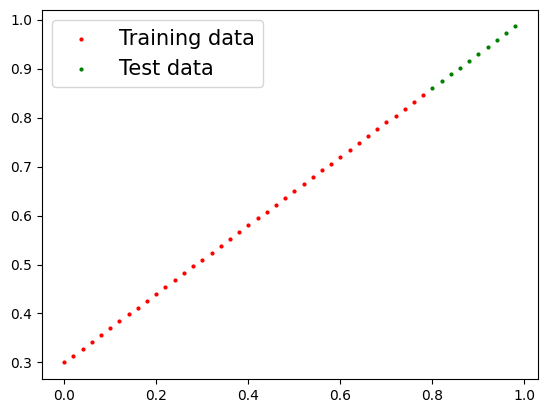

In [ ]:
plot_prediction();

create a Model using training data, Model will determine weight & bias values

what our Model does:
1. start with random values (weight & bias)
2. Look at training data and adjust these random values(or get closer to) ideal values (the actual weight & bias we used to create training & test data)

to do so it uses 2 main algorithms:
1. Gradient descent   - https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropagation - https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [ ]:
from torch import nn

# create a linear Regression Model class
class LinearRegressionModel(nn.Module):  # <-- almost everything in pyTorch is inheritted from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,      # --> start with a random weight and try to adjust it to ideal weight
                                            requires_grad=True,
                                            dtype=torch.float32))

    self.bias = nn.Parameter(torch.randn(1,         # --> start with a random bias and try to adjust it to ideal bias
                                        requires_grad=True,
                                        dtype=torch.float32))

  # forward method to define the computation in the module
  def forward(self, x: torch.Tensor) -> torch.Tensor:   # <-- "x" is the input data
      return self.weights * x + self.bias # linear regression formula

  PyTorch essentials:
  * torch.nn   -   provides all building blocks [its a tool set]
  * torch.nn.Parameter - const values our Model should learn & predict
  * torch.nn.Module  - base class
  * torch.optim - optimize parameters to get actuals
  * def forward - takes data from nn.Module and defines what happens in {forward} computation

In [ ]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()  # --> create a random instance of the class (this is subclass on nn.Module)

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

# Making prediction with torch.inference_mode()
to check our Models prediction power, lets see how it predicts y_test based on x_test

 --> when we pass data to the Model its going to run it through forward method


In [ ]:
# before using prediction power of our Model
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [ ]:
# with inference method, model is solely predicting values and not training the model. It is not keeping track of the things but just deriving the infenrence
# long story short ***Code runs faster***
# the older version is torch.no_grad()

with torch.inference_mode():
# with torch.no_grad():
  y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

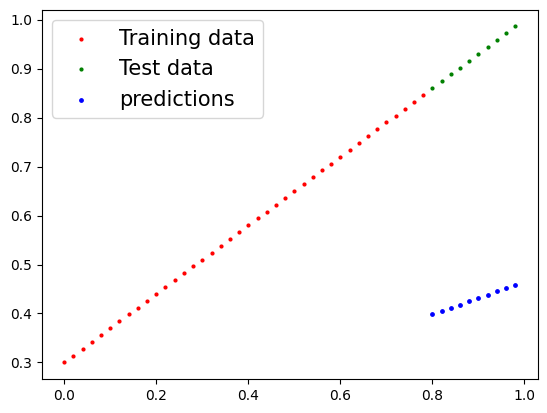

In [ ]:
plot_prediction(predictions=y_preds)

Train Model:

The whole idea of training the model, is moving from poorly predicted parameter values towards ideal parameter values

if we can meansure how poor the prediction is, it will be posible to adjust parameters to actual values

One way is to use Loss Function

Things we need to train:
*  **Loss Function**: The function to measure how wrong the model predictions are compared to the ideal output
*  **Optimizer** : Takes in account the loss of the model and adjust parameters to lower the loss.

for PyTorch we need:
*   **Training Loop**
*   **Testing Loop**

In [ ]:
# loss function
loss_fn = nn.L1Loss()

# optimizer SGD (Scholistic Gradient Descent)
optim_fn = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.01) # learning rate --> its a hyperparameter set manually, rate at which the loss

Building **training loop** (testing loop) in PyTorch :

we need:

0. Loop thorugh data
1. Forward pass (involves data passing through our model's foraward () function) to make prediction on data - also called forward propagation
2. calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimzer zero grad
4. Loss backward - move backwards throght the network to calculate gradients for each of the parameters of our model with respect to the loss (**back propagation**)
5. Optimizer step - use the optimizer to adjust the parameters to try and lower the loss (**Gradient Descent**)

In [ ]:
torch.manual_seed(42)

epochs = 100  # its a hyper parameter

# create empty array to track loss values
train_loss_values = []
test_loss_values = []
epoch_count = []

### Training Loop
# 0. loop through data
for epoch in range(epochs):

# set the model to training mode
  model_0.train()

# 1. forward Pass
  y_preds = model_0(X_train)

#2. calculate the loss function
  loss = loss_fn(y_preds, y_train)

# 3. optimizer zero grad
  optim_fn.zero_grad()

# 4. perform backward propagation on the loss with respect to the parameters in the model (calculate gradients of each parameter)
  loss.backward()

#5. optimizer step (perform gradient descent)
  optim_fn.step() # step the optimizer, to update the model's parameters with respect to the gradients calculated by step(4)

### testing Loop

# set model to testing mode
  model_0.eval()   # turns off settings in the model not needed for evaluation/testing (dropout/batch norm layer)

  with torch.inference_mode():  # turn off gradient tracking and some more settings

  # forward pass
    test_pred = model_0(X_test)

  # calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  # print the log
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      print(f'epoch: {epoch} MAE train-loss: {loss} MAE test-loss: {test_loss}')
      print(model_0.state_dict())


epoch: 0 MAE train-loss: 0.024458957836031914 MAE test-loss: 0.05646304413676262
OrderedDict([('weights', tensor([0.5800])), ('bias', tensor([0.3503]))])
epoch: 10 MAE train-loss: 0.021020207554101944 MAE test-loss: 0.04819049686193466
OrderedDict([('weights', tensor([0.5972])), ('bias', tensor([0.3433]))])
epoch: 20 MAE train-loss: 0.01758546568453312 MAE test-loss: 0.04060482233762741
OrderedDict([('weights', tensor([0.6141])), ('bias', tensor([0.3358]))])
epoch: 30 MAE train-loss: 0.014155393466353416 MAE test-loss: 0.03233227878808975
OrderedDict([('weights', tensor([0.6313])), ('bias', tensor([0.3288]))])
epoch: 40 MAE train-loss: 0.010716589167714119 MAE test-loss: 0.024059748277068138
OrderedDict([('weights', tensor([0.6485])), ('bias', tensor([0.3218]))])
epoch: 50 MAE train-loss: 0.0072835334576666355 MAE test-loss: 0.016474086791276932
OrderedDict([('weights', tensor([0.6654])), ('bias', tensor([0.3143]))])
epoch: 60 MAE train-loss: 0.0038517764769494534 MAE test-loss: 0.0082

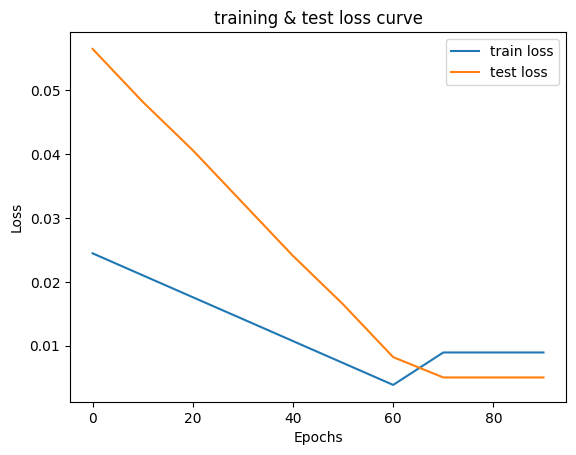

In [ ]:
# plot the loss curves
plt.plot(epoch_count, train_loss_values, label="train loss")
plt.plot(epoch_count, test_loss_values, label="test loss")
plt.title("training & test loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

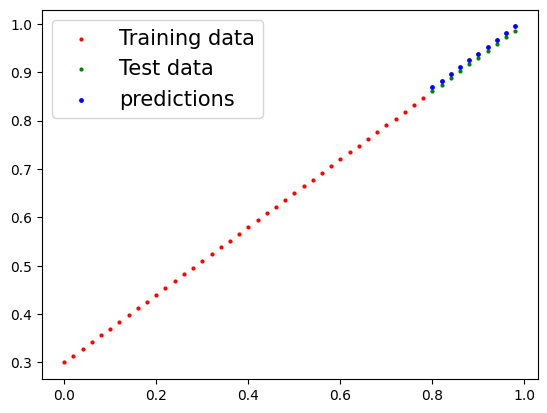

In [ ]:
plot_prediction(predictions=test_pred)  # after adding testing loop

**Saving & loading Pytorch Models**

 save pyToch object with '.pt/ .pth' extention to diskFile. It is recommended to save state_dict instead of entire pyToch Model. **state_dict** - maps each layer to its parameter tensor.

pyTorch Methods:

torch.save - Saves a serialized object to disk using Python's pickle utility.

torch.load - Use unpickling features to deserialize and load pickled Python object files

torch.nn.Module.load_state_dict - loads model's parameter dictionary using saved state_dict() object

In [ ]:
from pathlib import Path

# create Models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#Create Model save path
MODEL_NAME = "pytorch_workflow_model_0.pt"
MODEL_SAVE_PATH = MODEL_PATH/ MODEL_NAME

# save the model's state_dict
print(f'saving to: {MODEL_SAVE_PATH}')
torch.save(model_0.state_dict(),  # only saves the models learned parameters
           f=MODEL_SAVE_PATH)

saving to: models/pytorch_workflow_model_0.pt


##  Loding PyTorch Model
using saved state_dict() parameters, we will create a new instance of our model

In [ ]:
loaded_model_0 = LinearRegressionModel()   # create new instance of the class

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))  # load saved state_dict of model_0

<ipython-input-32-e86b9a66f60c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
model_0.eval()    # to comapre loaded model preds with original model preds

with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

# **Putting it Together (Revise)**

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu121'

In [2]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using device : {device}')

using device : cuda


In [3]:
weight = 0.8
bias = 0.4

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10] , y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.4000],
         [0.4160],
         [0.4320],
         [0.4480],
         [0.4640],
         [0.4800],
         [0.4960],
         [0.5120],
         [0.5280],
         [0.5440]]))

In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

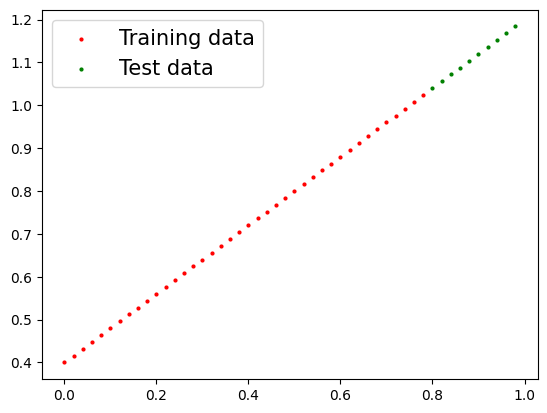

In [7]:
plot_prediction(X_train, y_train, X_test, y_test)

In [9]:

class LRModel(nn.Module):
  def __init__(self):
    super().__init__()

   # use nn.Linear() for creating model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# set the manual seed
torch.manual_seed(42)
model_l = LRModel()
model_l, model_l.state_dict()

(LRModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [10]:
X_train[:5], y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.4000],
         [0.4160],
         [0.4320],
         [0.4480],
         [0.4640]]))

In [11]:
# check the model current device
next(model_l.parameters()).device

device(type='cpu')

In [12]:
# set the model to use the target device
model_l.to(device)
next(model_l.parameters()).device

device(type='cuda', index=0)

In [15]:
# set up loss function
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params= model_l.parameters(),
                            lr=0.001)

In [16]:
torch.manual_seed(42)

epochs = 200

# put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
 ## training  loop
  model_l.train()

  y_predict = model_l(X_train)

  loss = loss_fn(y_predict, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

## testing  loop
  model_l.eval()

  with torch.inference_mode():
    test_predict = model_l(X_test)

    test_loss = loss_fn(test_predict, y_test)

  if epoch % 10 == 0:
    print(f'epoch: {epoch} | trainning loss: {loss} | test loss: {test_loss}')

epoch: 0 | trainning loss: 0.06271307915449142 | test loss: 0.12254667282104492
epoch: 10 | trainning loss: 0.051192235201597214 | test loss: 0.1090758666396141
epoch: 20 | trainning loss: 0.040377046912908554 | test loss: 0.09610942751169205
epoch: 30 | trainning loss: 0.032735466957092285 | test loss: 0.08496329933404922
epoch: 40 | trainning loss: 0.027593379840254784 | test loss: 0.07568798214197159
epoch: 50 | trainning loss: 0.024193426594138145 | test loss: 0.06809061020612717
epoch: 60 | trainning loss: 0.02195104770362377 | test loss: 0.06187736615538597
epoch: 70 | trainning loss: 0.020443657413125038 | test loss: 0.05684247240424156
epoch: 80 | trainning loss: 0.019424034282565117 | test loss: 0.05276073142886162
epoch: 90 | trainning loss: 0.018683310598134995 | test loss: 0.04945627599954605
epoch: 100 | trainning loss: 0.01811881922185421 | test loss: 0.04680922254920006
epoch: 110 | trainning loss: 0.017639676108956337 | test loss: 0.04456094652414322
epoch: 120 | trainn

In [17]:
model_l.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7283]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.4301], device='cuda:0'))])

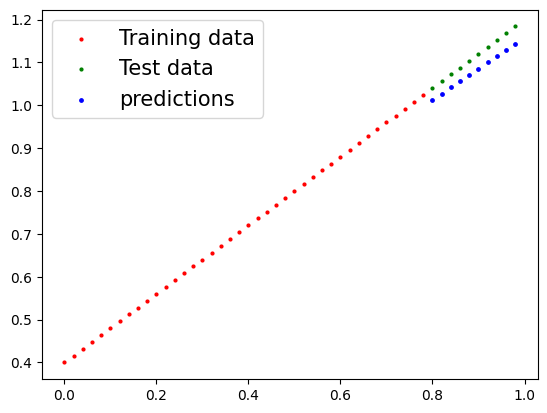

In [19]:
model_l.eval()

with torch.inference_mode():
  y_predict_test = model_l(X_test)

plot_prediction(predictions=y_predict_test.cpu())